In [73]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
#from modules import calc_spinylm as sylm
#from modules import local_eb_kernel as rko
from modules_v1 import euler as euler
from modules_v1 import rs_rad_ker as rk
from modules_v1 import  convert_qu2eb as qb
from modules_v1 import aliasing_correction as ac
from scipy.interpolate import interp1d


%pylab notebook
import time

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [74]:
nside=512 ; npix=h.nside2npix(nside)
sampling=4500
lmax=3*nside

pxsize=sqrt(4.*pi/h.nside2npix(nside))
beta0=min(180,180.*32/(3*nside))*pi/180. ; print beta0*180/pi

theta,pl2=rk.get_plm0(lmax,sampling,theta_max=3.*beta0)

3.75


In [75]:
#cltemp=h.read_cl("../../data/planck_wp_highL_lensing_param.fits")
cltemp=h.read_cl("../../data/cl_rem3.fits")
clr=[cltemp[0],cltemp[1],cltemp[2],cltemp[3]*0]
#random.seed(0) ; tqu=h.synfast(cllens,nside,lmax=lmax,mmax=lmax,pol=True,new=True,verbose=False)
#alm=h.map2alm(tqu,lmax=lmax)
#teb=h.alm2map(alm,nside,pol=False)
#cl=h.alm2cl(alm)

In [76]:
def get_alm(cl,lmax,seed=0):
    random.seed(seed)
    almsize=h.Alm.getsize(lmax,lmax)
    ar=random.normal(size=almsize)
    ai=random.normal(size=almsize)
    alm=zeros(almsize,complex)
    for i in range(almsize):
        l,m=h.Alm.getlm(lmax,i)
        if m==0:
            alm[i]=complex(ar[i],0.)*sqrt(cl[l])
        else:
            alm[i]=complex(ar[i],ai[i])*sqrt(0.5*cl[l])
    return alm

In [77]:
almt=get_alm(clr[0],lmax,1) ; alme=get_alm(clr[1],lmax,2) ; almb=get_alm(clr[2],lmax,3)
true_alm=[almt,alme,almb] ; cltrue=h.alm2cl(true_alm)

tqu=h.alm2map(true_alm,nside,pol=True) ; alm=h.map2alm(tqu,lmax=lmax)
cl=h.alm2cl(alm) ; teb=h.alm2map(alm,nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [78]:
true_teb=h.alm2map(true_alm,nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [79]:
theta_cutoff=2.*beta0

print theta_cutoff/pi, theta_cutoff*180./pi

0.0416666666667 7.5


In [80]:
apow=rk.fn_apodization(theta,theta_cutoff=theta_cutoff,apow_frac=0.8)
rad_ker=rk.calc_qu2eb_rad_ker(lmax,theta,pl2)# Default
rad_ker_i,rad_ker_d=rk.calc_qu2queb_rad_ker(lmax,theta,pl2)# Default
#rad_ker=rk.mod_rad_ker(theta,shift=0.05,amp=1,width=0.01,slope=2,expslope=2)# Modified

#ell=arange(lmax+1)
#gl=ell**2.
#rad_ker=rk.get_gbeta_from_gl(theta,gl,pl2)

<IPython.core.display.Javascript object>


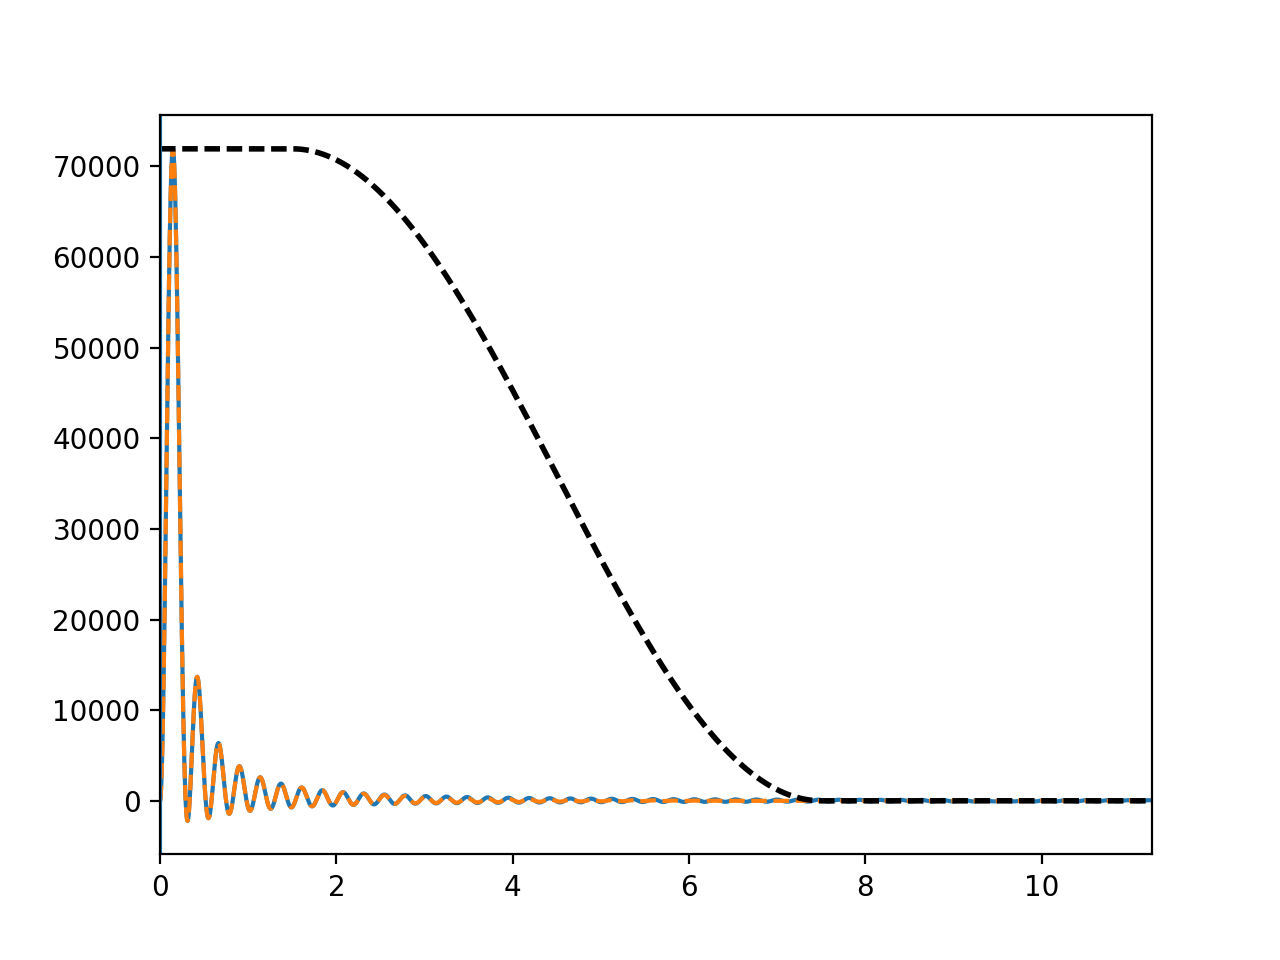

In [82]:
figure()
plot(theta*180./pi,rad_ker)
plot(theta*180./pi,rad_ker*apow,"--")
#plot(theta,rad_ker_i,"--")
plot(theta*180./pi,apow*max(rad_ker),"k--",lw=2)
axvline(pxsize)
xlim(0,1.5*theta_cutoff*180./pi)
rad_ker=rad_ker*apow

In [83]:
ell=arange(lmax+1)
gl=rk.get_gl_from_gbeta(theta,rad_ker,pl2,theta_cutoff,lmax) ;# gl[0:2]=1
rec_rad_ker=rk.get_gbeta_from_gl(theta,gl,pl2)

<IPython.core.display.Javascript object>


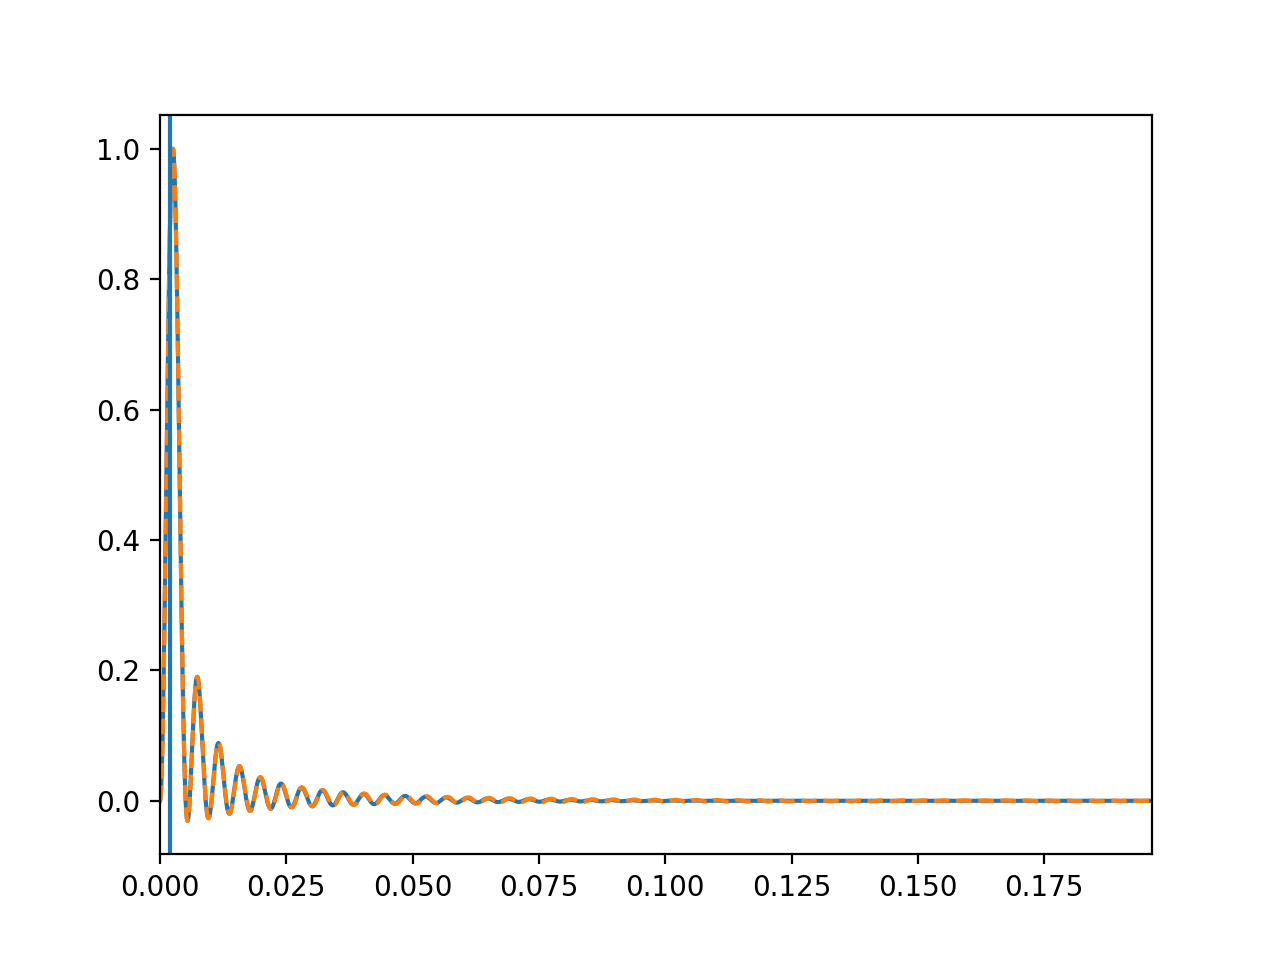

(0, 0.19634954084936207)

In [84]:
figure()
plot(theta,rad_ker/max(rad_ker))
plot(theta,rec_rad_ker/max(rec_rad_ker),"--")
axvline(pxsize)
xlim(0,1.5*theta_cutoff)
#loglog()

#figure()
#plot(arange(lmax+1),gl)
#plot(arange(lmax+1),1)
#axhline(0)
#semilogx()
#loglog()

<IPython.core.display.Javascript object>


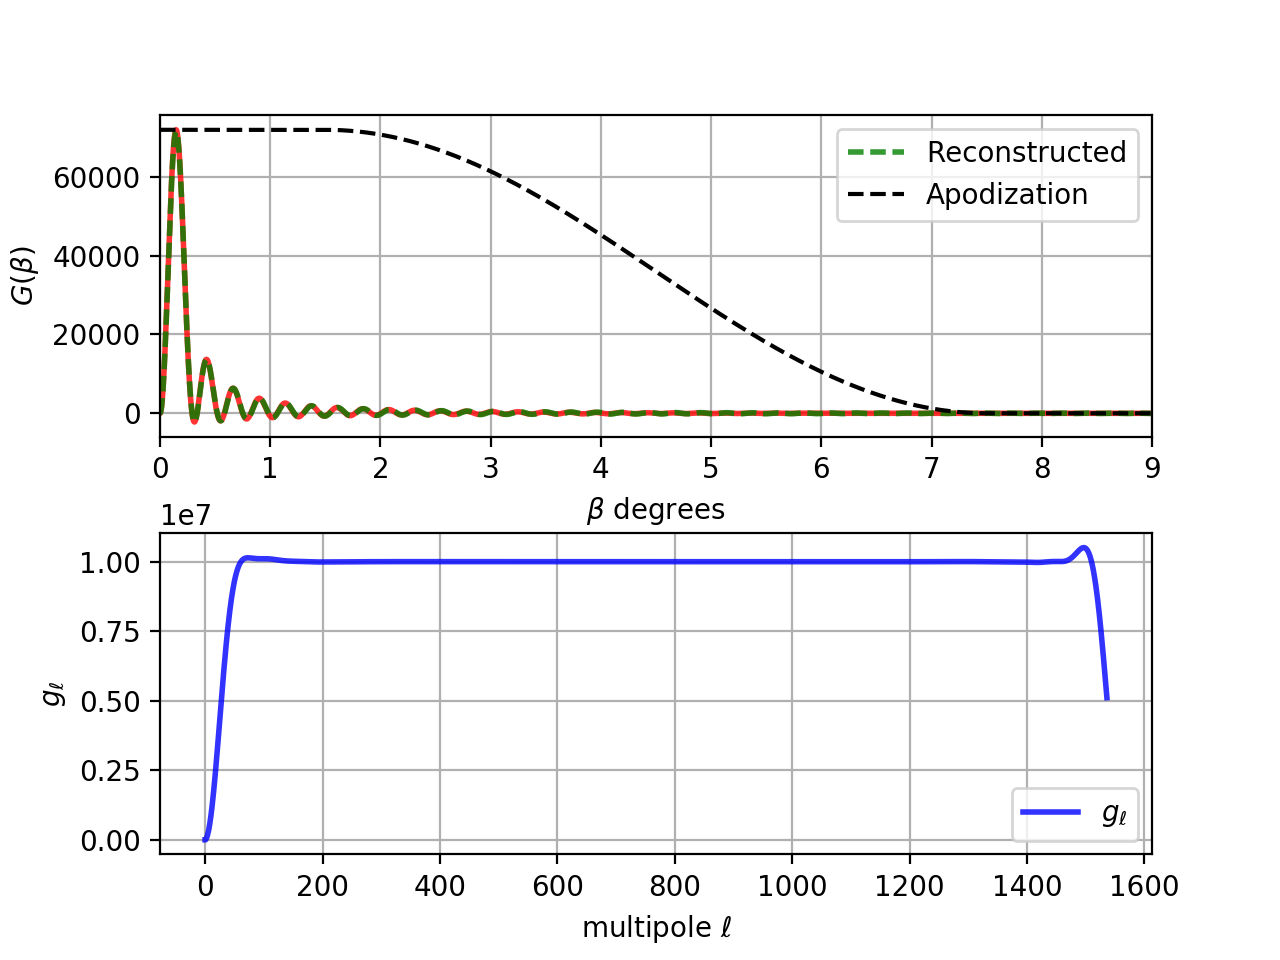

In [85]:
f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)
ax1.plot(theta*180./pi,rad_ker,"r-",lw=2,label="",alpha=0.8)
ax1.plot(theta*180./pi,rec_rad_ker,"g--",lw=2,label="Reconstructed",alpha=0.8)
ax1.plot(theta*180./pi,apow*max(rad_ker),"k--",label="Apodization")
ax1.grid()
ax1.legend(loc=0)
ax1.set_xlim(0,1.2*theta_cutoff*180./pi)
ax1.set_xlabel(r"$\beta$ degrees")
ax1.set_ylabel(r"$G(\beta)$")

ax2.plot(ell,gl*1e7,"b-",lw=2,label=r"$g_{\ell}$",alpha=0.8)
ax2.grid()
ax2.legend(loc=0)
ax2.set_xlabel(r"multipole $\ell$")
ax2.set_ylabel(r"$g_{\ell}$")
f.subplots_adjust(hspace=0.3)
savefig("../../figures/default_rad_ker_spectral_response_rcutoff_4deg.pdf",dpi=300,bbox_inches="tight")

#theta0=2.*pi/180. ; phi0=0.
#cpix=h.ang2pix(nside,theta0,phi0)
#tqu=[zeros(npix,float),zeros(npix,float),zeros(npix,float)] ; tqu[2][cpix]=1.
#alm=h.map2alm(tqu,lmax=lmax)
#teb=h.alm2map(alm,nside,pol=False)
#cl=h.alm2cl(alm)

<IPython.core.display.Javascript object>


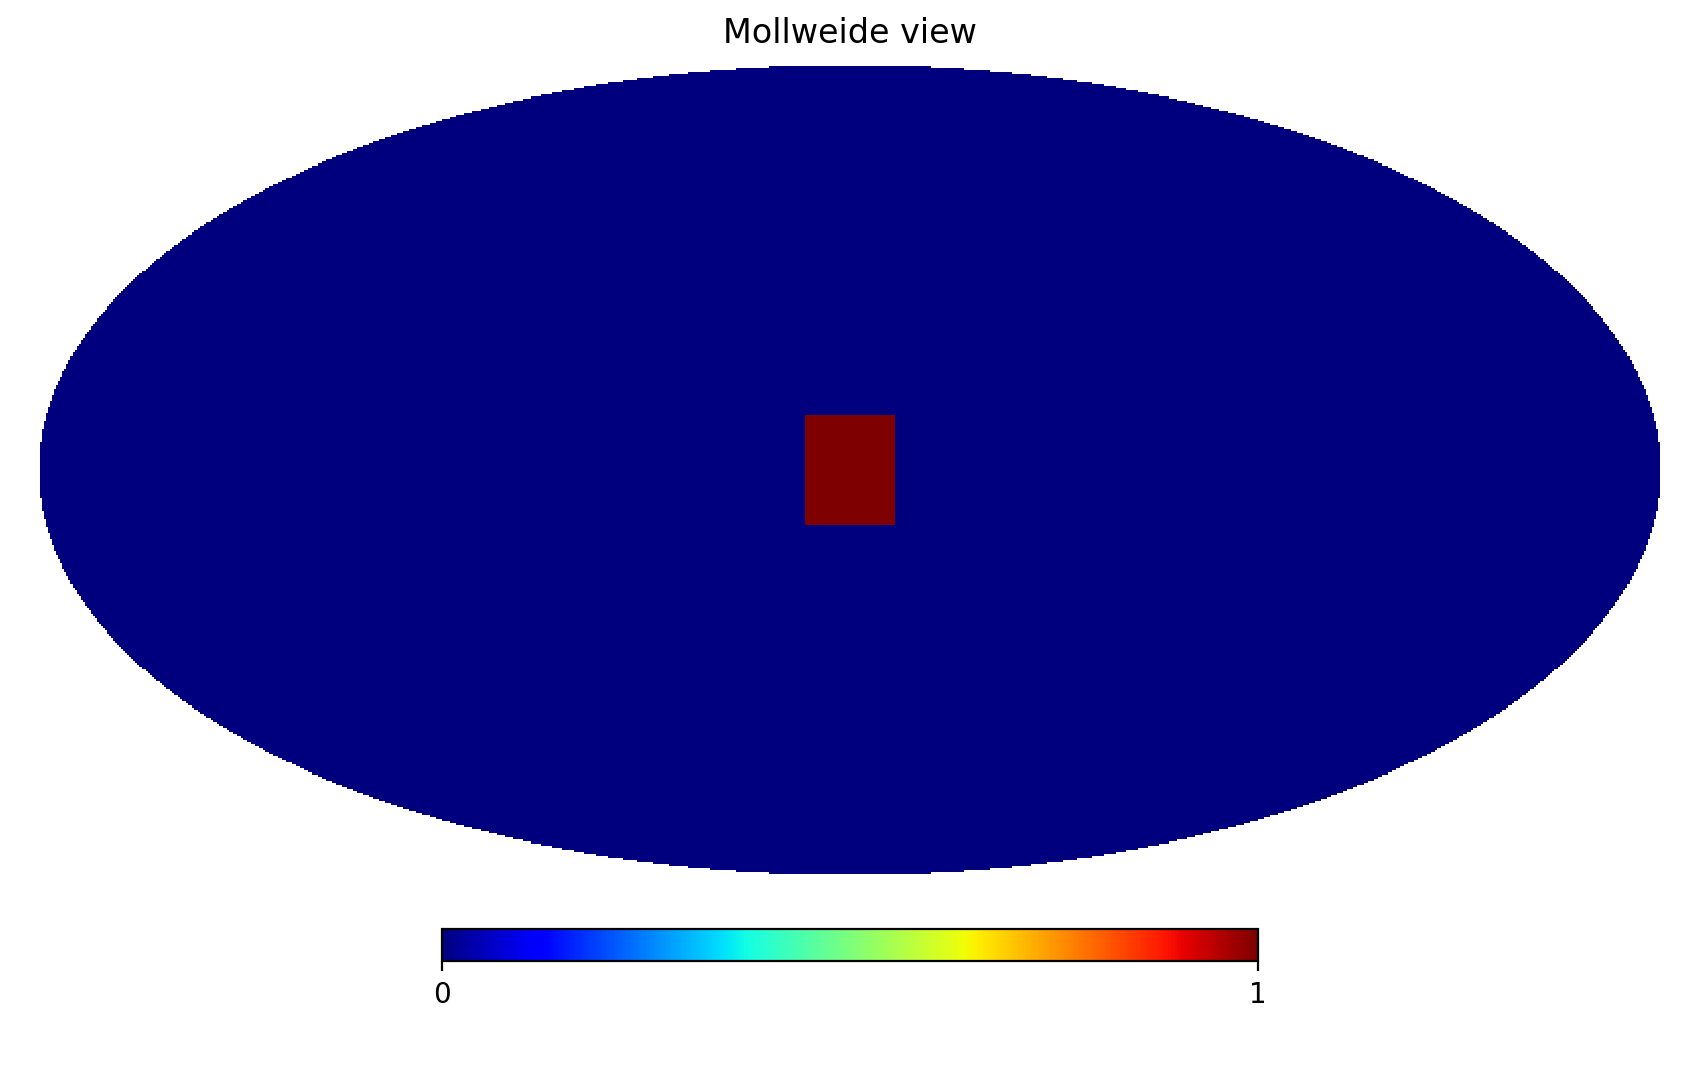

In [86]:
lat=90
tmask=zeros(npix,float)
pmask=zeros(npix,float)
pindex=arange(npix)
theta0,phi0=h.pix2ang(nside,pindex)
theta0=theta0*180/pi ; phi0=phi0*180/pi
wband=10 ; phiband=10
tmask[theta0<lat-wband]=1 ; tmask[theta0>lat+wband]=1.
pmask[phi0<phiband]=1. ; pmask[phi0>360-phiband]=1.
mask=pmask*(1-tmask) ; fsky=sum(mask)/size(mask)

h.mollview(mask)

In [72]:
ctqu=ac.correct_aliasing_convolve(tqu[1],tqu[2],theta_cutoff,theta,rad_ker_i,iter=3,mask=mask)

<IPython.core.display.Javascript object>


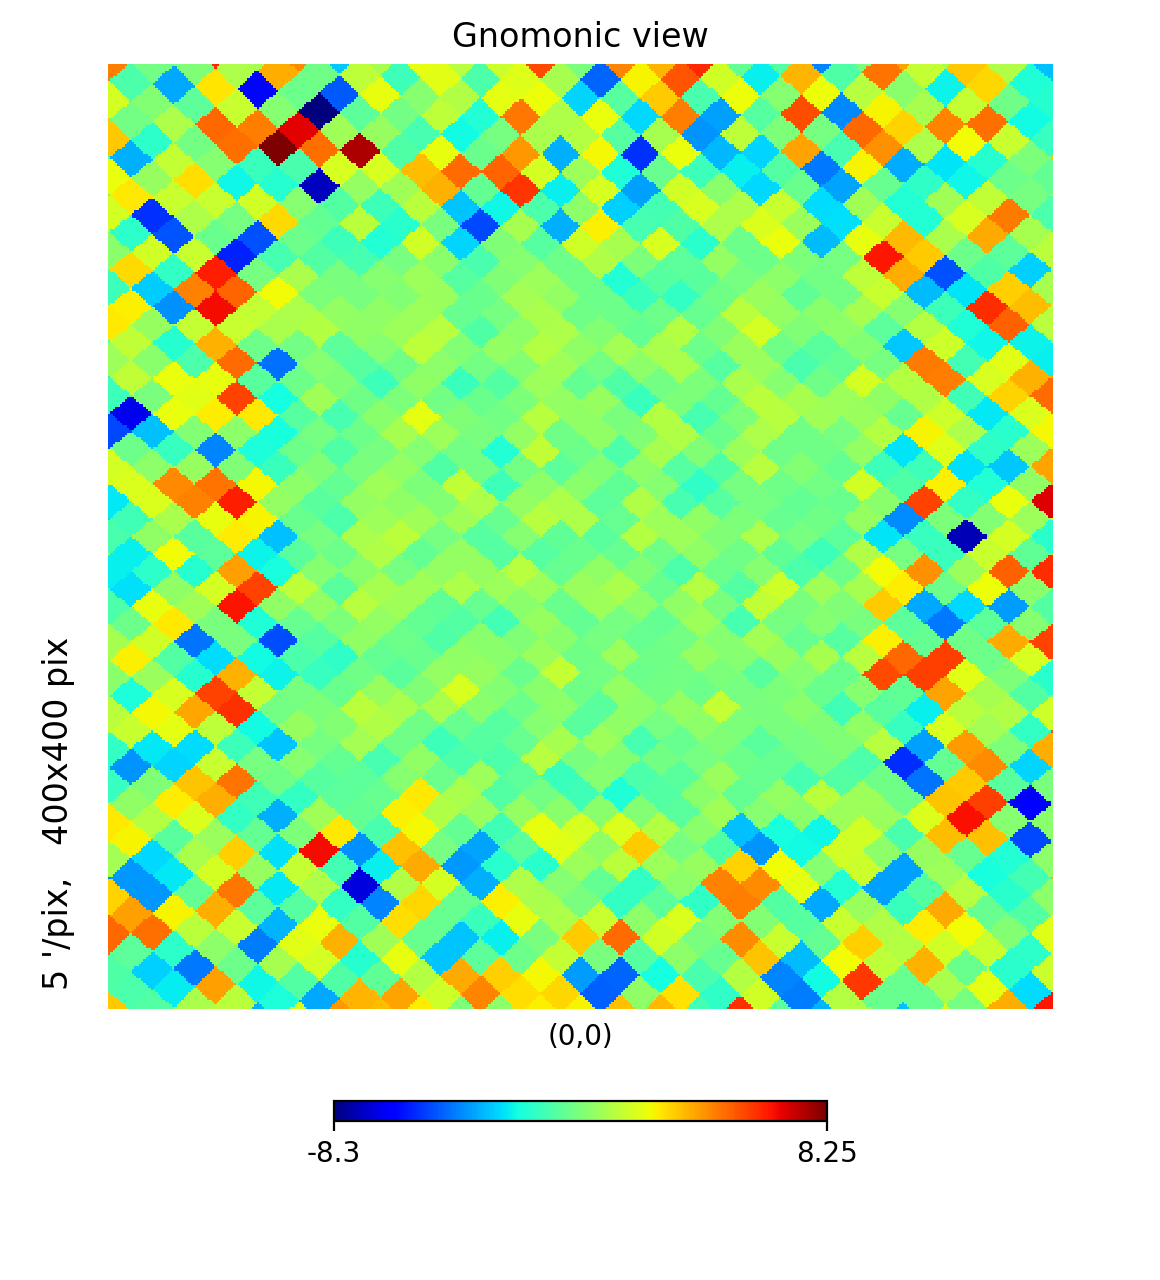

<IPython.core.display.Javascript object>


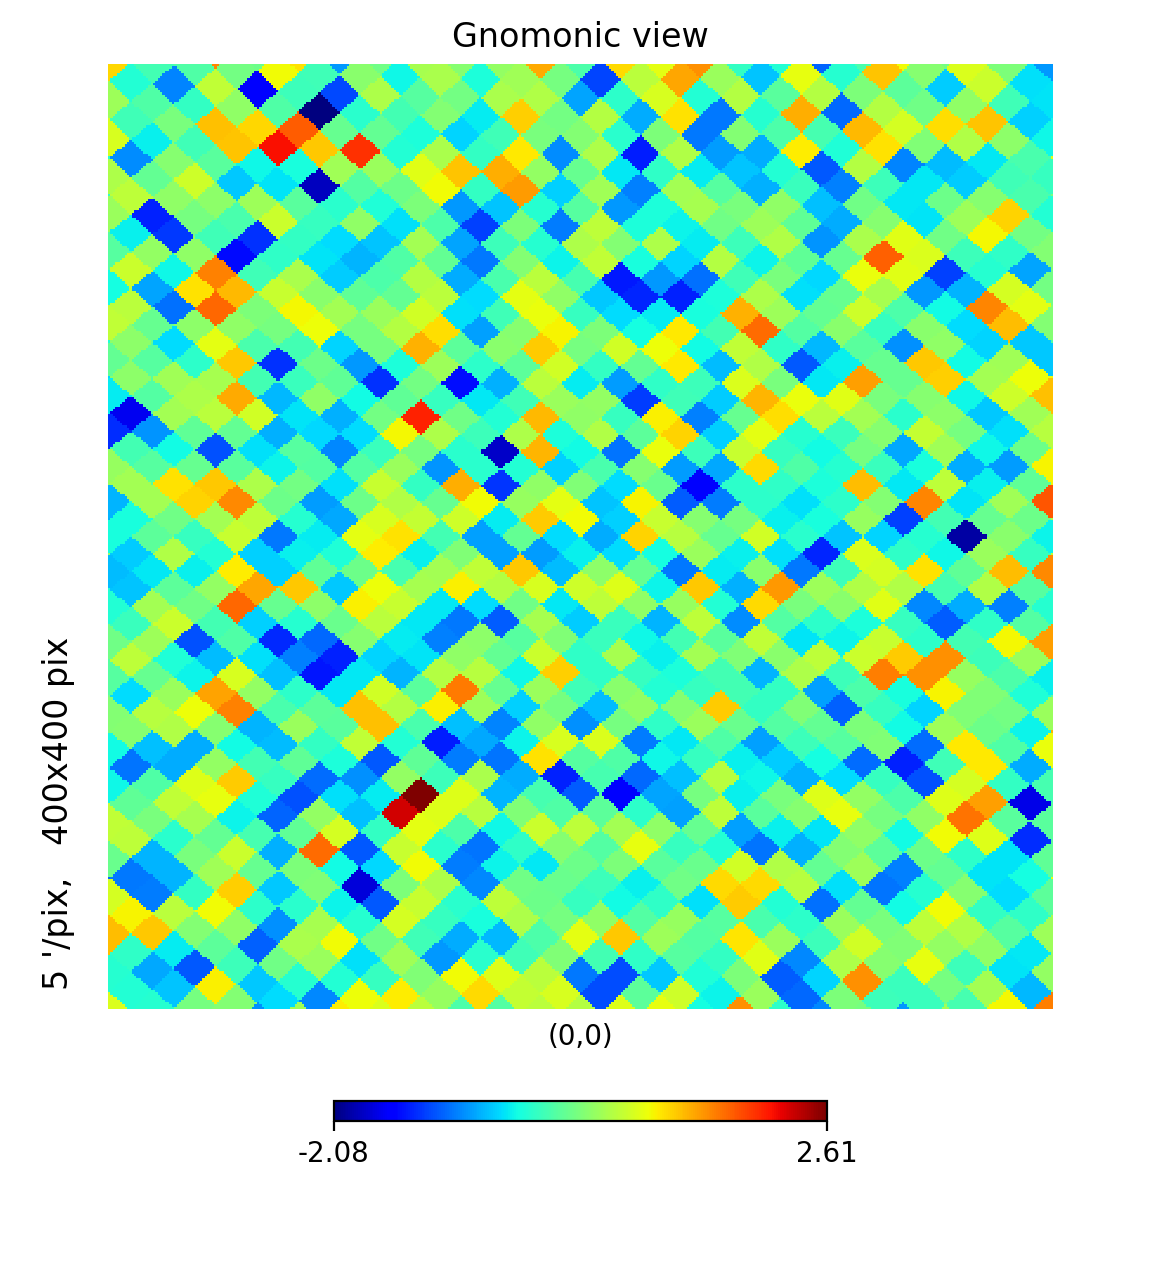

In [66]:
h.gnomview(ctqu[1],xsize=400,reso=5)#,min=-0.5,max=0.5)
h.gnomview(tqu[1],xsize=400,reso=5)#,min=-0.5,max=0.5)

In [87]:
#t1=time.time()
#rtebo=qb.convert_qu2eb_radiate_masked(ctqu[1],ctqu[2],theta_cutoff,theta,rad_ker,mask=mask)
#print time.time()-t1

t1=time.time()
rteb=qb.convert_qu2eb_integrate_masked(tqu[1],tqu[2],theta_cutoff,theta,rad_ker,mask=mask)
print time.time()-t1

114.08302784


alm=h.map2alm(rteb,lmax=lmax)
alm=[h.almxfl(alm[i],1./gl,inplace=True) for i in range(3)]
rtebp=h.alm2map(alm,nside,pol=False)

alm=h.map2alm(rtebo,lmax=lmax)
alm=[h.almxfl(alm[i],1./gl,inplace=True) for i in range(3)]
rtebop=h.alm2map(alm,nside,pol=False)

h.write_map("../../figures/new_results/radiating_rteb_masked.fits",rtebo,overwrite=True)
h.write_map("../../figures/new_results/integrated_rteb_masked.fits",rteb,overwrite=True)
h.write_map("../../figures/new_results/teb_fullsky.fits",teb,overwrite=True)
h.write_map("../../figures/new_results/mask.fits",mask,overwrite=True)

<IPython.core.display.Javascript object>


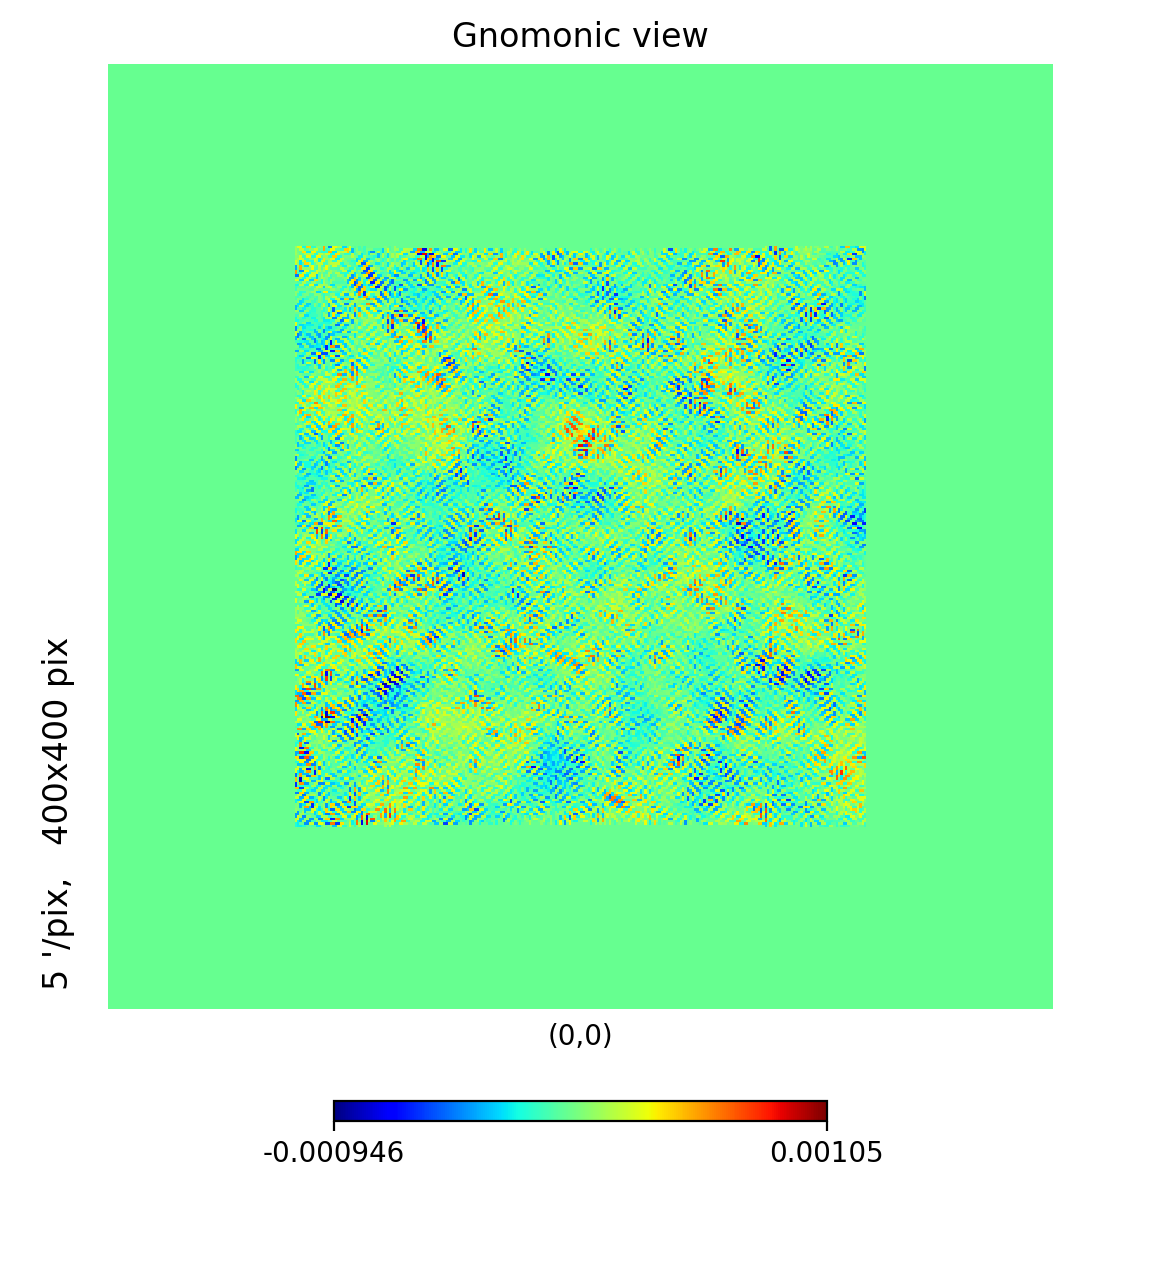

<IPython.core.display.Javascript object>


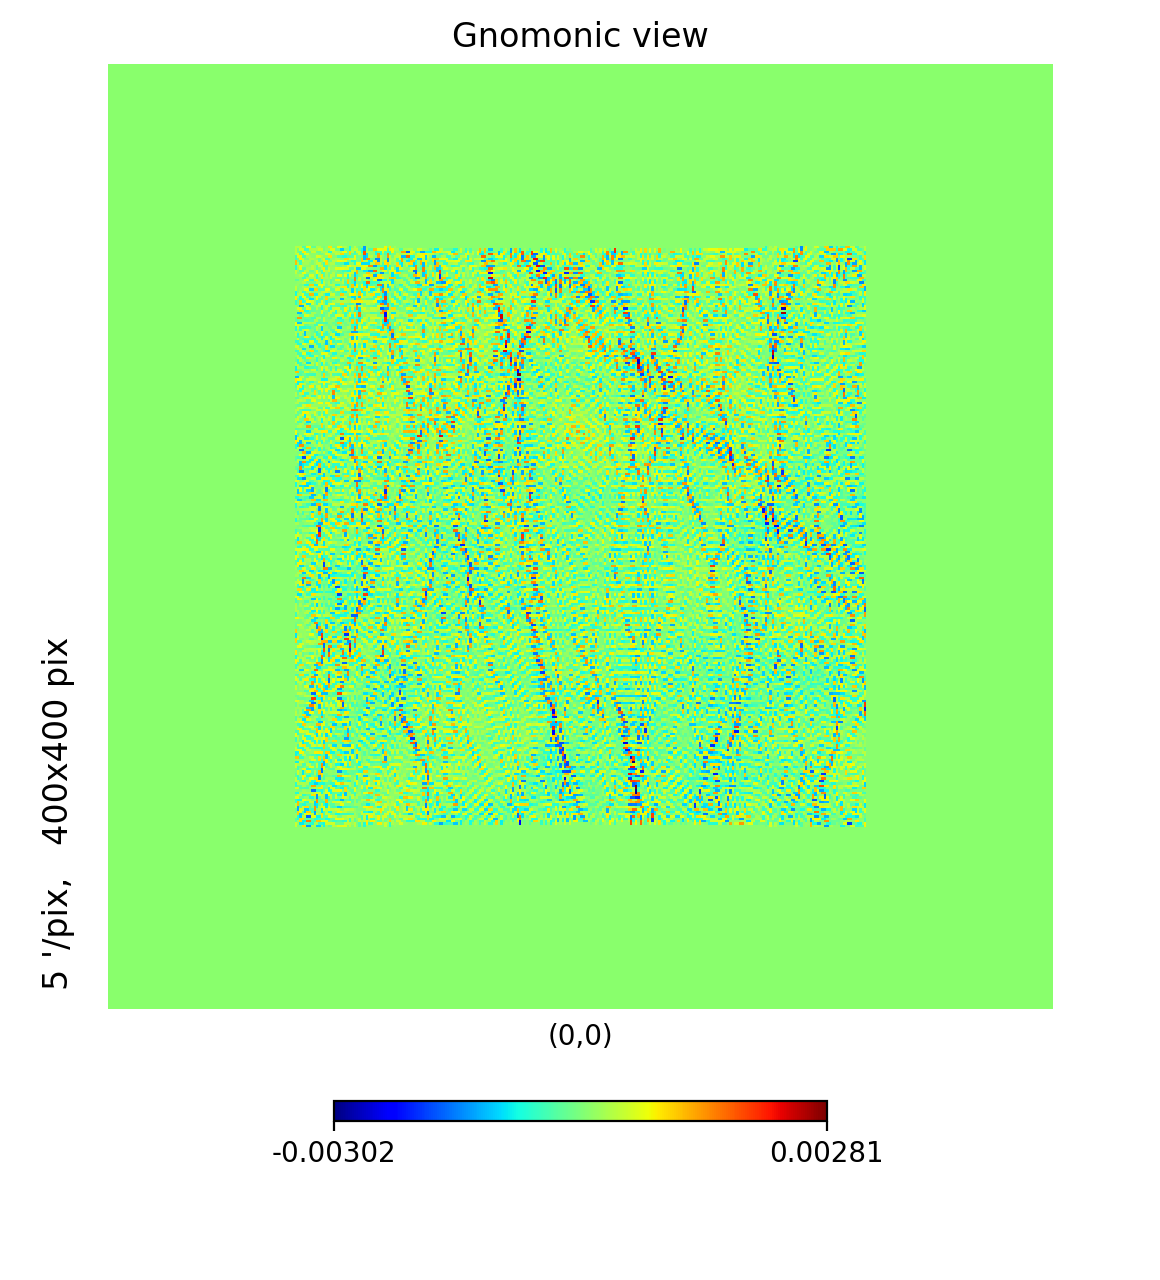

In [88]:
#h.mollview(rtebo[2])
#h.mollview(rteb[2])
#h.mollview(teb[2]*mask)

#h.gnomview(rtebo[2],xsize=400,reso=5,rot=(0,90-lat))
h.gnomview(rteb[2],xsize=400,reso=5,rot=(0,90-lat))
h.gnomview(teb[2]*mask,xsize=400,reso=5,rot=(0,90-lat))

In [89]:
clrteb=h.alm2cl(h.map2alm(rteb*mask,lmax=lmax,pol=False,iter=3))
#clrtebo=h.alm2cl(h.map2alm(rtebo*mask,lmax=lmax,pol=False))
clhteb=h.alm2cl(h.map2alm(teb*mask,lmax=lmax,pol=False,iter=3))
cltteb=h.alm2cl(h.map2alm(true_teb*mask,lmax=lmax,pol=False,iter=3))

<IPython.core.display.Javascript object>


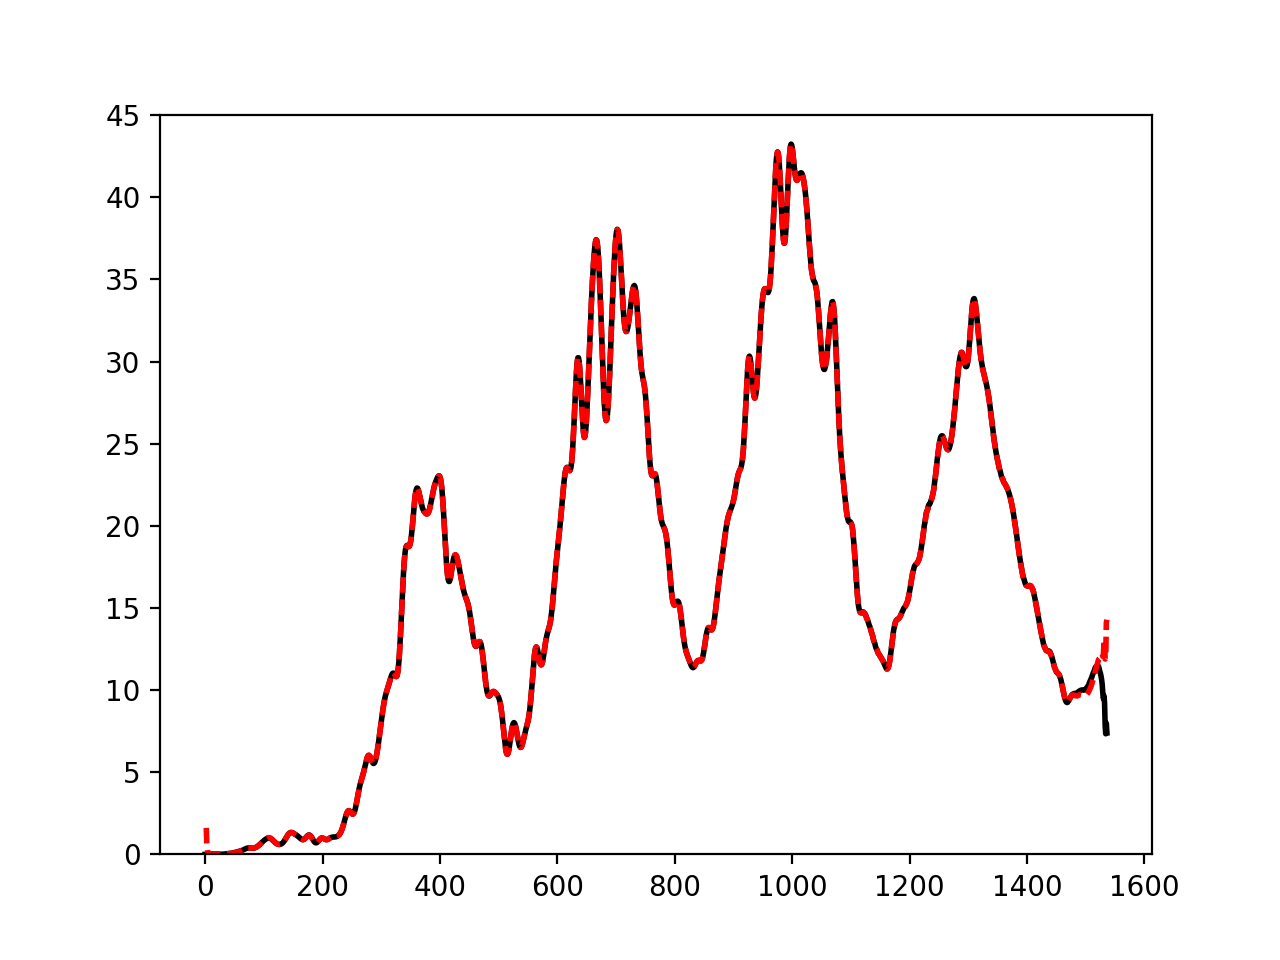

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


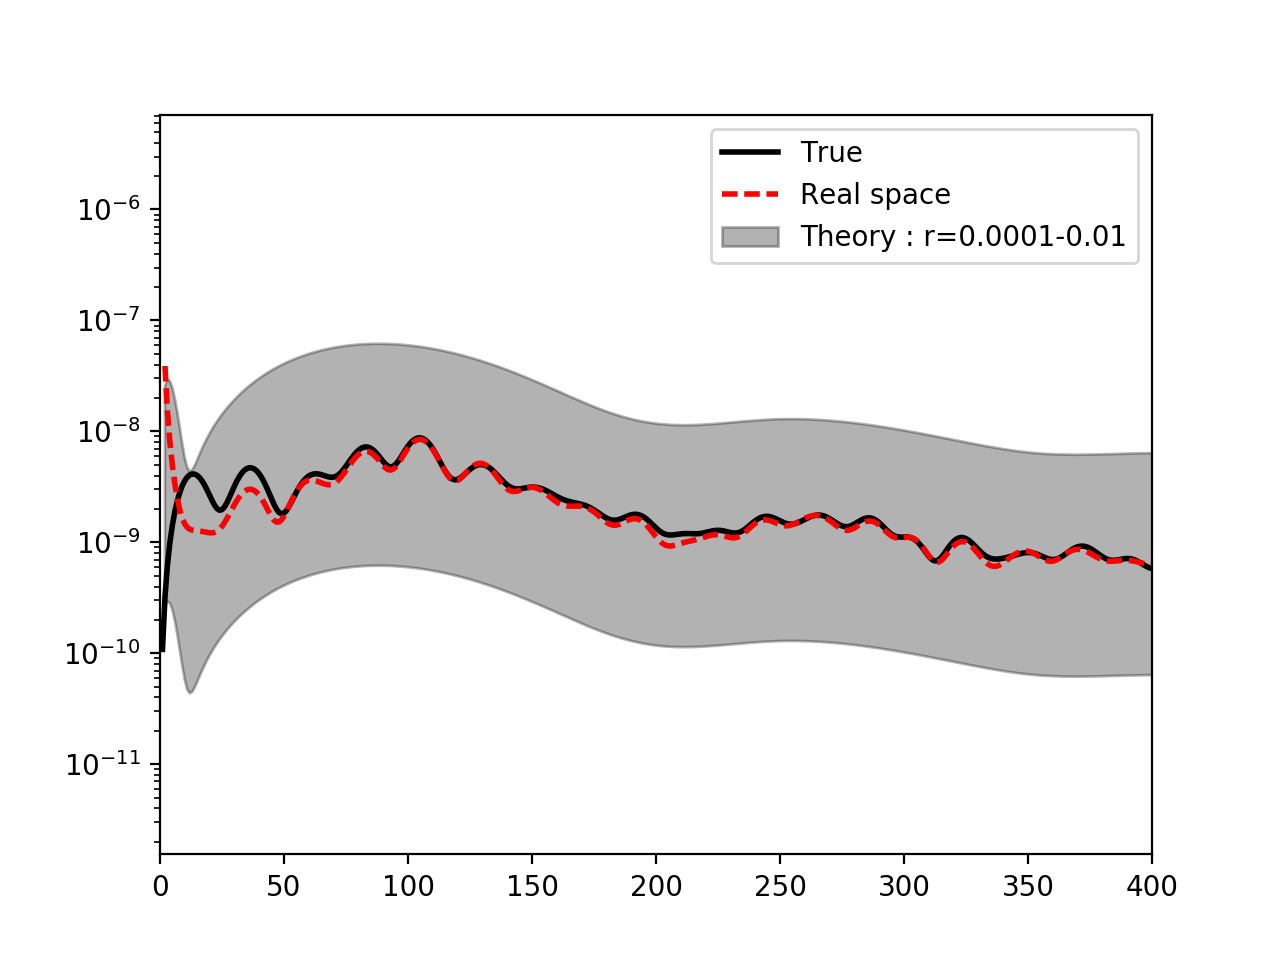

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


(0, 400)

In [90]:
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

figure()
plot(ell,fll*cltteb[1]/fsky,"k-",lw=2,label="True")
#plot(ell,fll*clhteb[1]/fsky,"b-",lw=2,label="Healpix")
plot(ell,fll*clrteb[1]/(gl*gl*fsky),"r--",lw=2,label="Real space")
#plot(ell,fll*clrtebo[1]/(gl*gl*fsky),"m--")
#semilogy()
#loglog()
#semilogx()
ylim(1e-4,45)

figure()
plot(ell,fll*cltteb[2]/fsky,"k-",lw=2,label="True")
#plot(ell,fll*clhteb[2]/fsky,"b-",label="Healpix")
plot(ell,fll*clrteb[2]/(gl*gl*fsky),"r--",lw=2,label="Real space")
#plot(ell,fll*clrtebo[2]/(gl*gl*fsky),"m--")
fill_between(ell,fll*cltemp[2][:lmax+1]*0.1,fll*cltemp[2][:lmax+1]*10,color="k",alpha=0.3,label="Theory : r=0.0001-0.01")
legend(loc=0)
semilogy()
xlim(0,400)
#loglog()
#ylim(1e-10,1e-8)

<IPython.core.display.Javascript object>


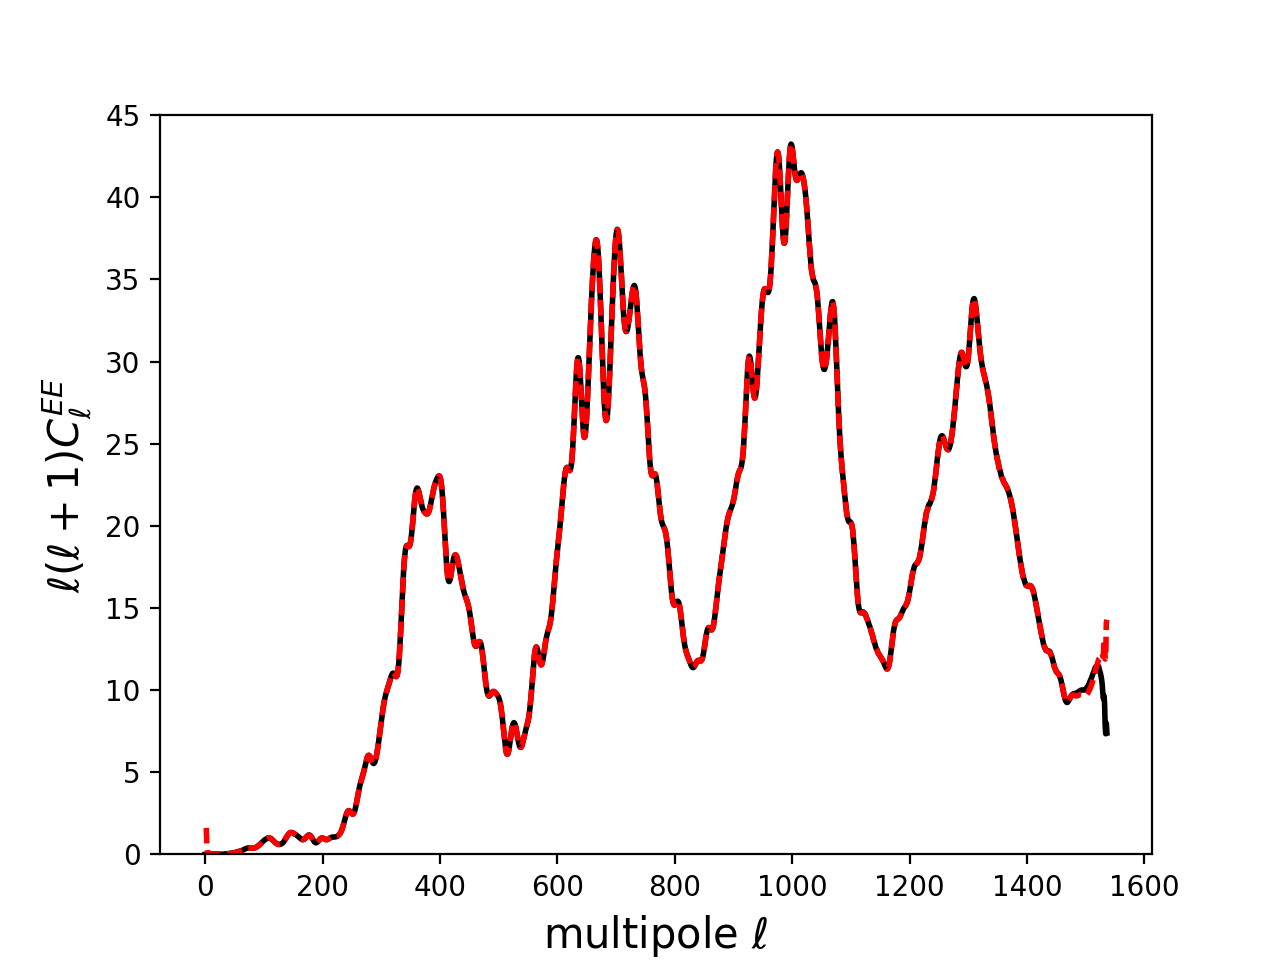

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


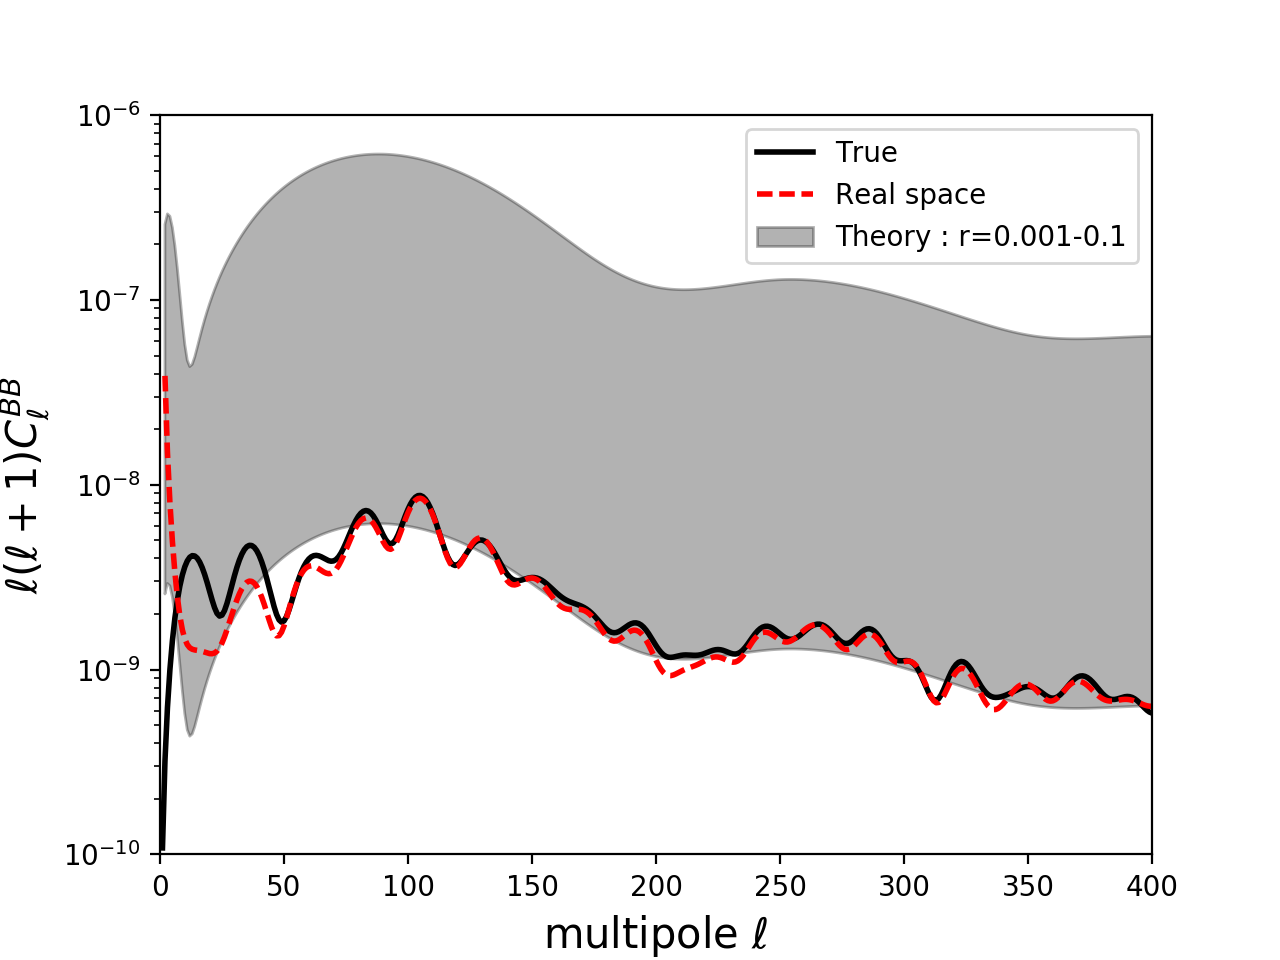

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in divide
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide


In [91]:
ell=arange(lmax+1)
fll=ell*(ell+1)/(2.*pi)

figure()
plot(ell,fll*cltteb[1]/fsky,"k-",lw=2,label="True")
plot(ell,fll*clrteb[1]/(gl*gl*fsky),"r--",lw=2,label="Real space")
ylim(1e-4,45)
ylabel("$\ell(\ell+1)C_{\ell}^{EE}$",fontsize=15)
xlabel("multipole $\ell$",fontsize=15)
savefig("../../figures/real_space_ee_spectra.pdf",dpi=300,bbox_inches="tight")

figure()
plot(ell,fll*cltteb[2]/fsky,"k-",lw=2,label="True")
plot(ell,fll*clrteb[2]/(gl*gl*fsky),"r--",lw=2,label="Real space")
fill_between(ell,fll*cltemp[2][:lmax+1],fll*cltemp[2][:lmax+1]*100,color="k",alpha=0.3,label="Theory : r=0.001-0.1")
legend(loc=0)
semilogy()
xlim(0,400)
ylim(1e-10,1e-6)
ylabel("$\ell(\ell+1)C_{\ell}^{BB}$",fontsize=15)
xlabel("multipole $\ell$",fontsize=15)
savefig("../../figures/real_space_bb_spectra.pdf",dpi=300,bbox_inches="tight")

In [36]:
#figure()
#plot(ell,(1.-gl**2.)*100.,"b-")
#plot(ell,(clhteb[1]-clrteb[1])*100/clhteb[1],"r--")
#plot(ell,(clhteb[2]-clrteb[2])*100/clhteb[2],"g--")




#plot(ell,(clhteb[1]-cltteb[1])*100/clhteb[1],"k-")
#ylim(-10,10)
#semilogx()